# AI in Digital Pathology

> The use of artificial intelligence will transform clinical practice over the next decade and the early impact of this will likely be the integration of image analysis and machine learning into routine histopathology. In the UK and around the world, a digital revolution is transforming the reporting practice of diagnostic histopathology and this has sparked a proliferation of image analysis software tools. While this is an exciting development that could discover novel predictive clinical information and potentially address international pathology workforce shortages, there is a clear need for a robust and evidence‐based framework in which to develop these new tools in a collaborative manner that meets regulatory approval. With these issues in mind, the NCRI Cellular Molecular Pathology (CM‐Path) initiative and the British In Vitro Diagnostics Association (BIVDA) have set out a roadmap to help academia, industry, and clinicians develop new software tools to the point of approved clinical use.

<span class="fn"><i>[REF]</i>Colling, Richard, et al. “Artificial intelligence in digital pathology: A roadmap to routine use in clinical practice.” The Journal of pathology 249.2 (2019)</span>

# Whole-Slide Image Preprocessing

>Whole Slide Images (`WSIs`), namely the translation of tissue slides from glass to digital format, are a great source of information from both a medical and a computational point of view. 
>
> `WSIs` can be coloured with different staining techniques (e.g. `H&E` or `IHC`), and are usually very large in size (up to several GB per slide). 
> Because of WSIs typical pyramidal structure, images can be retrieved at different magnification factors, providing a further layer of information beyond color.

>However, processing `WSIs` is far from being trivial. 
> 
> First of all, `WSIs` can be stored in different proprietary formats, according to the scanner used to digitalize the slides, and a standard protocol is still missing. 
> 
> `WSIs` can also present artifacts, such as shadows, mold, or annotations (pen marks) that are not useful. Moreover, giving their dimensions, it is not possible to process a `WSI `all at once, or, for example, to feed a neural network: it is necessary to crop smaller regions of tissues (tiles), which in turns require a tissue detection step.

<span class="fn">(Short excerpt from) https://histolab.readthedocs.io/en/latest/</span>

## TUPAC

The primary goal of the **Tumor Proliferation Assessment Challenge** 2016 (TUPAC16) was to develop algorithms to automatically predict breast cancer tumor proliferation scores. 

In this challenge, the training set consisted of `500` whole-slide images that are scored 
(`1`, `2`, or `3`) by pathologists based on **mitosis** counts. 

A **higher proliferation score** indicates a worse prognosis because higher tumor proliferation rates are correlated with worse outcomes. 

The tissue samples are stained with hematoxylin and eosin (H&E).

Tissue identification in whole-slide images can be an important precursor to deep learning. Deep learning is computationally expensive and medical whole-slide images are enormous. Typically, a large portion of a slide isn’t useful, such as the background, shadows, water, smudges, and pen marks. You can use preprocessing to rapidly reduce the quantity and increase the quality of the image data to be analyzed. This can lead to faster, more accurate model training.

In this series, we’ll look at whole-slide image processing and will describe various filters that can be used to increase the accuracy of tissue identification. After determining a useful set of filters for tissue segmentation, we’ll divide slides into tiles and determine sets of tiles that typically represent good tissue samples.

The solution should demonstrate high performance, flexibility, and accuracy. Filters should be easy to combine, chain, and modify. Tile scoring should be easy to modify for accurate tile selection. The solution should offer the ability to view filter, tile, and score results across large, unique datasets. The solution should also have the ability to work in a batch mode, where all of the image files and intermediary files are written to the file system, and in a dynamic mode, where high-scoring tissue tiles can be retrieved from the original WSI files without requiring any intermediary files.

In summary, we will scale down whole-slide images (WSI), apply filters to these scaled-down images for tissue segmentation, break the slides into tiles, score the tiles, and then retrieve the top tiles based on their scores.

<img src="https://developer.ibm.com/developer/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt1/images/5-steps.png" class="maxw90" />

<span class="fn"><i>Source:</i> https://developer.ibm.com/technologies/data-science/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt1/</span>

###### Preparation

**if in COLAB**

```bash
%%shell

apt update && apt install -y openslide-tools
pip install openslide-python
```

if the latter did not work, try:

```bash
!pip install git+https://github.com/openslide/openslide-python.git
```

In [3]:
!pip install git+https://github.com/openslide/openslide-python.git

  Cloning https://github.com/openslide/openslide-python.git to /private/var/folders/7q/d1cx0m912238pv5hzwzg97tmyxm5lm/T/pip-req-build-v3ycodyg
  Running command git clone -q https://github.com/openslide/openslide-python.git /private/var/folders/7q/d1cx0m912238pv5hzwzg97tmyxm5lm/T/pip-req-build-v3ycodyg
  Created wheel for openslide-python: filename=openslide_python-1.1.1-cp37-cp37m-macosx_10_9_x86_64.whl size=16136 sha256=7a6f7d1c035f150f8f99f0ed935fa8dc79bf53c659138873520e57ee5b08f852
  Stored in directory: /private/var/folders/7q/d1cx0m912238pv5hzwzg97tmyxm5lm/T/pip-ephem-wheel-cache-qngk2eqz/wheels/c9/a6/95/a00276675bb4d2b593edfd8be1aea9918c140cb978414e6805
Successfully built openslide-python


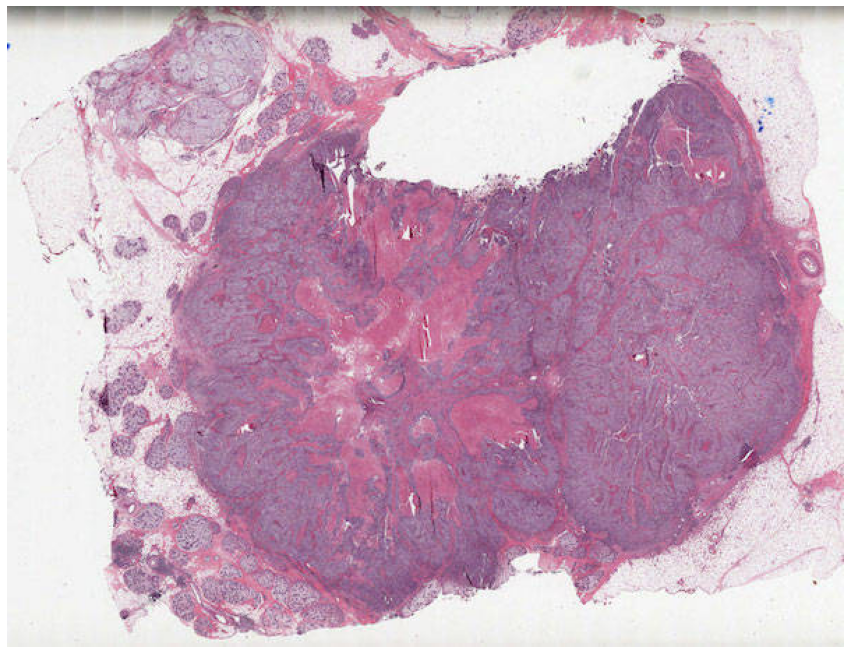

In [9]:
from matplotlib import pyplot as plt 
from imageio import imread

target_image = './wsi-example.jpg'

plt.figure(figsize=(15, 15))
plt.imshow(imread(target_image))
plt.axis('off')
plt.show()

A whole-slide image is created by a microscope that scans a slide and combines smaller images into a large image. 

Techniques include **combining scanned** square tiles into a whole-slide image and combining scanned strips into a resulting whole-slide image. Occasionally, the smaller constituent images can be visually discerned, as in the shaded area at the top of the following slide.

**TUPAC Dataset**: http://tupac.tue-image.nl/node/3

$\Rightarrow$ Example Image (HR): https://drive.google.com/file/d/0B--ztKW0d17XM3RVOFRuZEMwd1E/view?usp=sharing 

`TUPAC-TR-004.svs` (`563MB`)

For a very detailed tutorial on the required preprocessing for WSI images, see 

[Whole-slide image preprocessing in Python](https://developer.ibm.com/technologies/data-science/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt1/) by IBM Research
[Part II](https://developer.ibm.com/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt2/)

#### Introducing `histolab`

> [...]processing WSIs is far from being trivial. First of all, WSIs can be stored in different proprietary formats, according to the scanner used to digitalize the slides, and a standard protocol is still missing. WSIs can also present artifacts, such as shadows, mold, or annotations (pen marks) that are not useful. Moreover, giving their dimensions, it is not possible to process a WSI all at once, or, for example, to feed a neural network: it is necessary to crop smaller regions of tissues (tiles), which in turns require a tissue detection step.

```shell
!pip install histolab
```

###### Extracting Slides

```python
from histolab.slide import Slide

breast_slide = Slide(breast_path, processed_path='processed')

print(f"Slide name: {breast_slide.name}")
print(f"Dimensions at level 0: {breast_slide.dimensions}")
print(f"Dimensions at level 1: {breast_slide.level_dimensions(level=1)}")
print(f"Dimensions at level 2: {breast_slide.level_dimensions(level=2)}")
```

###### Working on Tiles

```python
from histolab.tiler import RandomTiler

random_tiles_extractor = RandomTiler(
    tile_size=(512, 512),
    n_tiles=6,
    level=2,
    seed=42,
    check_tissue=True,
    prefix="processed/breast_slide/",
)

random_tiles_extractor.extract(breast_slide)
```

![](https://user-images.githubusercontent.com/31658006/84955724-0f1a9600-b0f8-11ea-92c9-3236dd16bca8.png)

```python
random_tiles_extractor = RandomTiler(
    tile_size=(512, 512),
    n_tiles=6,
    level=0,
    seed=42,
    check_tissue=True,
    prefix="processed/heart_slide/",
)

random_tiles_extractor.extract(heart_slide)
```

![](https://user-images.githubusercontent.com/31658006/84955793-2c4f6480-b0f8-11ea-8970-592dc992d56d.png)

---

## Deep Learning and Digital Pathology

#### Transfer Learning (& Domain Adaptation)

>In practice, very few people train an entire Convolutional Network
 from scratch (with random initialization), because it is relatively
 rare to have a dataset of sufficient size. Instead, it is common to
 pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
 contains 1.2 million images with 1000 categories), and then use the
 ConvNet either as an initialization or a fixed feature extractor for
 the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.

### Transfer Learning in a Nutshell

**Reference**: [cs231n lecture notes](https://cs231n.github.io/transfer-learning/)


- **ConvNet as fixed feature extractor**. 
Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features **CNN codes**. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.

- **Fine-tuning the ConvNet**. 
The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.

- **Pretrained models**. 
Since modern ConvNets take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning. For example, the Caffe library has a [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) where people share their network weights.

In [3]:
import torch
from torchvision import models
from torch.optim import lr_scheduler

In [6]:
NUM_CLASSES = 10 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

![](https://gitlab.fbk.eu/mpba-histology/dapper/-/tree/dapper/)

![](dapper.png)

[Repo: Dapper Tissue Classification](https://gitlab.fbk.eu/mpba-histology/dapper)